In [1]:
import os
import urllib.request
import zipfile
import copy
import time
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


torch:  2.0 ; cuda:  2.0.0.post2


In [13]:
data_dir = '../data'

# Set up transformations for training and validation (test) data
# For training data we will do randomized cropping to get to 224 * 224, randomized horizontal flipping, and normalization
# For test set we will do only center cropping to get to 224 * 224 and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create Datasets for training and validation sets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          data_transforms['val'])

# Create DataLoaders for training and validation sets
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)

# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}

# Store size of training and validation sets
dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset)}
# Get class names associated with labels
class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


torch.Size([4, 3, 224, 224])


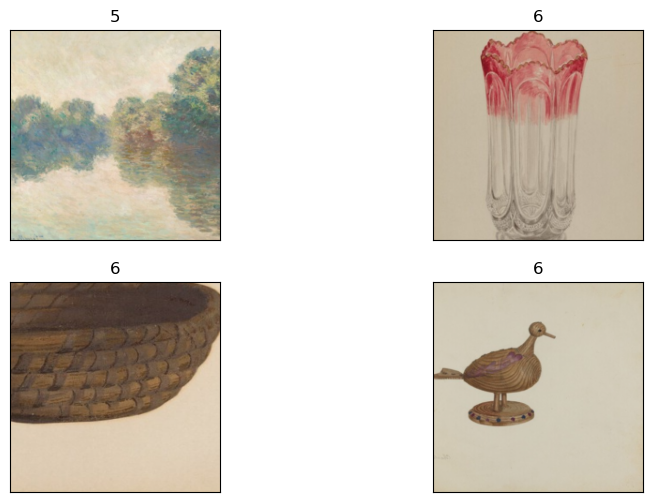

In [14]:
# Visualize a batch of images
images, labels = next(iter(train_loader))
print(images.shape)
images = images.numpy()
fig = plt.figure(figsize=(10, 6))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title("{}".format(class_names[labels[idx]]))

In [15]:
# Instantiate pre-trained resnet
net = torchvision.models.resnet50(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in net.parameters():
    param.requires_grad = False

# Display a summary of the layers of the model and output shape after each layer
summary(net,(images.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 112, 112]           9,408
       BatchNorm2d-2          [4, 64, 112, 112]             128
              ReLU-3          [4, 64, 112, 112]               0
         MaxPool2d-4            [4, 64, 56, 56]               0
            Conv2d-5            [4, 64, 56, 56]           4,096
       BatchNorm2d-6            [4, 64, 56, 56]             128
              ReLU-7            [4, 64, 56, 56]               0
            Conv2d-8            [4, 64, 56, 56]          36,864
       BatchNorm2d-9            [4, 64, 56, 56]             128
             ReLU-10            [4, 64, 56, 56]               0
           Conv2d-11           [4, 256, 56, 56]          16,384
      BatchNorm2d-12           [4, 256, 56, 56]             512
           Conv2d-13           [4, 256, 56, 56]          16,384
      BatchNorm2d-14           [4, 256,

In [16]:
# Get the number of inputs to final Linear layer
num_ftrs = net.fc.in_features
# Replace final Linear layer with a new Linear with the same number of inputs but just 2 outputs,
# since we have 2 classes - bees and ants
net.fc = nn.Linear(num_ftrs, 7)

In [17]:
# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
def train_model(model, criterion, optimizer, dataloaders, scheduler, device, num_epochs=25):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

            # Step along learning rate scheduler when in train
            if phase == 'train':
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # If model performs better on val set, save weights as the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:3f}'.format(best_acc))

    # Load the weights from best model
    model.load_state_dict(best_model_wts)

    return model

In [19]:
# Learning rate scheduler - decay LR by a factor of 0.1 every 7 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the model
net = train_model(net, criterion, optimizer, dataloaders, lr_scheduler, device, num_epochs=10)

Epoch 0/9
----------


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


train Loss: 0.8673 Acc: 0.7218


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


val Loss: 0.6759 Acc: 0.7649

Epoch 1/9
----------


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


train Loss: 0.7891 Acc: 0.7401


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


val Loss: 0.6561 Acc: 0.7713

Epoch 2/9
----------


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


train Loss: 0.7659 Acc: 0.7439


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


val Loss: 0.6905 Acc: 0.7874

Epoch 3/9
----------


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


train Loss: 0.7292 Acc: 0.7488


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


val Loss: 0.6874 Acc: 0.7794

Epoch 4/9
----------


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


train Loss: 0.7308 Acc: 0.7576


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


val Loss: 0.5871 Acc: 0.8027

Epoch 5/9
----------


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


train Loss: 0.7246 Acc: 0.7594


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


val Loss: 0.6606 Acc: 0.7858

Epoch 6/9
----------


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


train Loss: 0.7010 Acc: 0.7661


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


val Loss: 0.6646 Acc: 0.7915

Epoch 7/9
----------


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


train Loss: 0.6053 Acc: 0.7910


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


val Loss: 0.5834 Acc: 0.8140

Epoch 8/9
----------


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


train Loss: 0.5849 Acc: 0.7993


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


val Loss: 0.5393 Acc: 0.8124

Epoch 9/9
----------


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


train Loss: 0.5934 Acc: 0.7871


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


val Loss: 0.5383 Acc: 0.8172

Training complete in 62m 39s
Best val Acc: 0.817230


In [25]:
torch.save(net, 'resnet50_finetuned.pth') # Save the model weights

/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


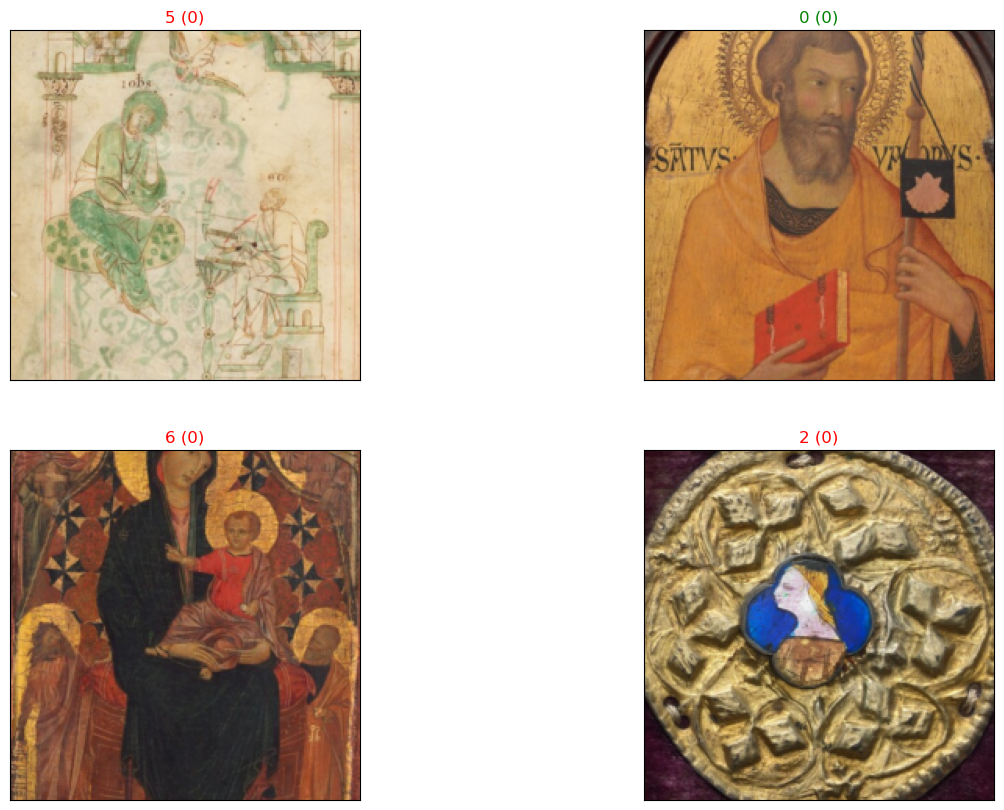

In [26]:
# Display a batch of predictions
def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = next(iter(val_loader))
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return
net = torch.load('resnet50_finetuned.pth')
visualize_results(net,val_loader,device)

In [27]:
# calculate the f1 score of the model
from sklearn.metrics import f1_score
def calculate_f1(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        all_preds = []
        all_labels = []
        # Get predictions and true labels
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            _,preds = torch.max(model(images), 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return f1_score(all_labels,all_preds,average='weighted')
print("F1 score: ", calculate_f1(net,val_loader,device))

/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


F1 score:  0.8135619939087235


/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")
/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jingwei/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN3c106detail19maybe_wrap_dim_slowExxb'
  warn(f"Failed to load image Python extension: {e}")


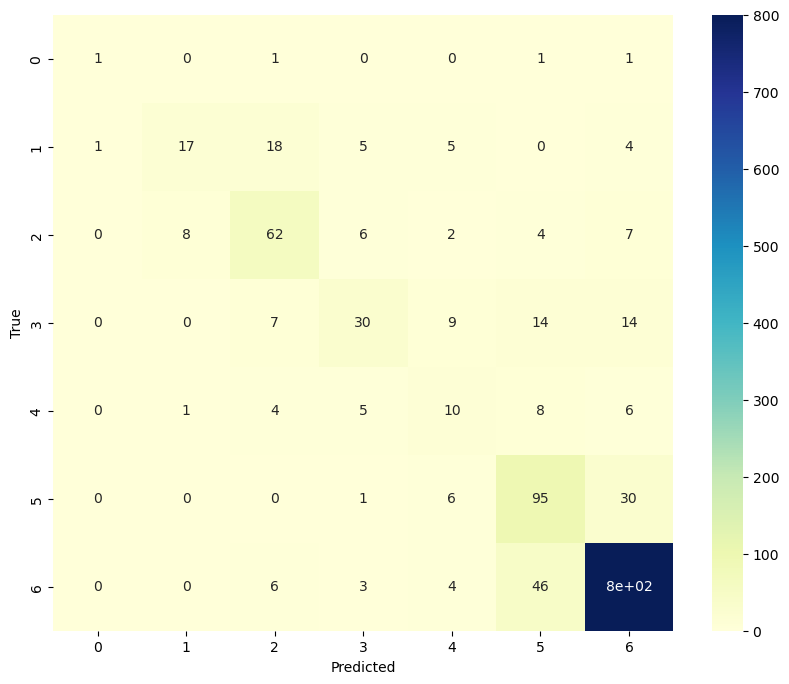

In [28]:
# draw a confusion matrix for me
from sklearn.metrics import confusion_matrix
import seaborn as sns
def draw_confusion_matrix(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        all_preds = []
        all_labels = []
        # Get predictions and true labels
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            _,preds = torch.max(model(images), 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels,all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
draw_confusion_matrix(net,val_loader,device)

# machine learning - svm

In [7]:
import os
import cv2
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# 数据文件夹路径
data_folder = "../data_aug/train"

# 读取图像数据和标签
def load_data(folder):
    images = []
    labels = []
    label_names = sorted(os.listdir(folder))
    for label_name in label_names:
        label_folder = os.path.join(folder, label_name)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = cv2.imread(img_path)
                try:                
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 转换为灰度图像
                    img = cv2.resize(img, (100, 100))  # 调整图像大小
                    img = img / 255.0  # 归一化
                    images.append(img.flatten())  # 将图像展平成一维数组
                    labels.append(label_name)
                except:
                    print("Error reading file: ", img_path)
    return np.array(images), np.array(labels)

# 加载数据
X, y = load_data(data_folder)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Error reading file:  ../data_aug/train/5/.DS_Store


In [8]:
# 训练SVM模型
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = clf.predict(X_test)

# 计算准确率和分类报告
accuracy = accuracy_score(y_test, y_pred)
print("准确率:", accuracy)
print("\n分类报告:\n", classification_report(y_test, y_pred))

准确率: 0.6749326145552561

分类报告:
               precision    recall  f1-score   support

           0       1.00      0.51      0.68        35
           1       0.74      0.36      0.48       134
           2       0.62      0.66      0.64       260
           3       0.75      0.34      0.47       195
           4       0.86      0.17      0.28       113
           5       0.59      0.78      0.68       426
           6       0.72      0.86      0.79       692

    accuracy                           0.67      1855
   macro avg       0.76      0.53      0.57      1855
weighted avg       0.70      0.67      0.65      1855



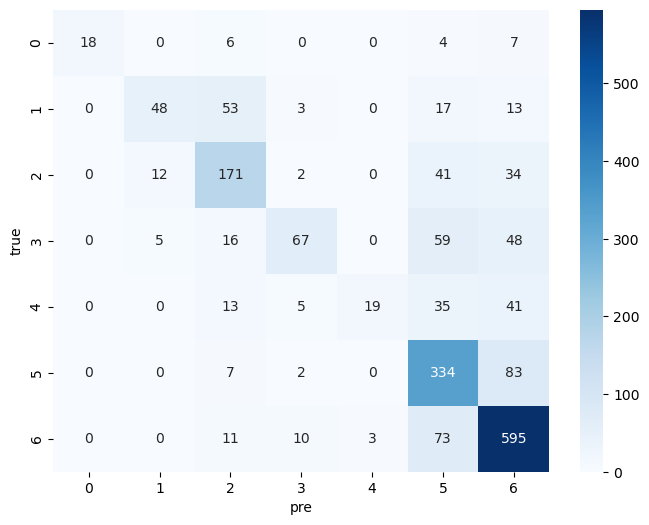

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 计算混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)

# 获取类别标签
labels = np.unique(y)

# 绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('pre')
plt.ylabel('true')
plt.show()
